In [2]:
import warnings
warnings.filterwarnings("ignore")
!pip install -r requirements.txt -q

In [3]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import re
import nltk
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

### Advanced Feature Extraction

In [7]:
data = pd.read_csv("fe_without_preprocessing_train.csv")

#### Preprocessing Text
- Preprocessing:
    1. Removing html tag
    2. Removing Punctuations
    3. Performing Stemming
    4. Removing Stopwords
    5. Expanding contractions

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /config/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
SAFE_DIV = 0.0001 # to get result in 4 decimal points

STOP_WORDS = stopwords.words('english')

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern,' ',x)

    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()

    return x

In [26]:
def get_token_features(q1, q2):
    token_features = [0.0]*10

    # Converting questions into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens)== 0 or len(q2_tokens)==0:
        return token_features

    # Getting non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOPWORDS])
    q2_words = set([word for word in q2_tokens if word not in STOPWORDS])

    # Getting stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOPWORDS])
    q2_stops = set([word for word in q2_tokens if word in STOPWORDS])

    # Getting the common non-stopwords from questions pair
    common_word_count = len(set(q1_words).intersection(set(q2_words)))

    # Getting the common stopwords from questions pair
    common_stop_count = len(set(q1_stops).intersection(set(q2_stops)))

    # Getting the common non-stopwords from questions pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both questions is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both questions is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

    # Average token length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b))+1)

def extract_features(df):
    # preprocessing each question
    df['question1'] = df["question1"].fillna("").apply(preprocess)
    df['question2'] = df["question2"].fillna("").apply(preprocess)

    print("Token features..........")

    # Merging features with dataset
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)

    df["cwc_min"]       = list(map(lambda x:x[0], token_features))
    df["cwc_max"]       = list(map(lambda x:x[1], token_features))
    df["csc_min"]       = list(map(lambda x:x[2], token_features))
    df["csc_max"]       = list(map(lambda x:x[3], token_features))
    df["ctc_min"]       = list(map(lambda x:x[4], token_features))
    df["ctc_max"]       = list(map(lambda x:x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x:x[6], token_features))
    df["first_word_eq"] = list(map(lambda x:x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x:x[8], token_features))
    df["mean_len"]      = list(map(lambda x:x[9], token_features))

    ## Computing fuzzy features
    print("Fuzzy Features........")

    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']),axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']),axis=1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']),axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']),axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']),axis=1)
    return df


In [4]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.444440,0.599988,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


#### Analysis of extracted features

- Creating Word Cloud of Dupicates and Non-duplicates Questions pairs
- We can observe the most frequent occuring words

In [6]:
df_duplicate = df[df['is_duplicate']==1]
df_non_duplicate = df[df['is_duplicate']==0]

## Converting 2d array of q1 and q2 then flattening it intp array
p = np.dstack([df_duplicate['question1'], df_duplicate["question2"]]).flatten()
n = np.dstack([df_non_duplicate['question1'], df_non_duplicate["question2"]]).flatten()

print("Number of data points in class 1 (duplicate pairs) :",len(p))
print("Number of data points in class 0 (non-duplicate pairs) :",len(n))

# Saving the np array into a text file
np.savetxt("train_p.txt",p, delimiter=' ', fmt='%s')
np.savetxt("train_n.txt",n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non-duplicate pairs) : 510054


In [10]:
## Reading the text files and removing the stop words
d = path.dirname('.')

textp_w = open(path.join(d,'train_p.txt')).read()
textn_w = open(path.join(d,'train_n.txt')).read()
stopwords = set(STOPWORDS)

stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

print("Total number of words in duplicate pair questions :",len(textp_w))
print("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110954
Total number of words in non duplicate pair questions : 33201584


###### Generating Word Cloud for Duplicate Question Pairs

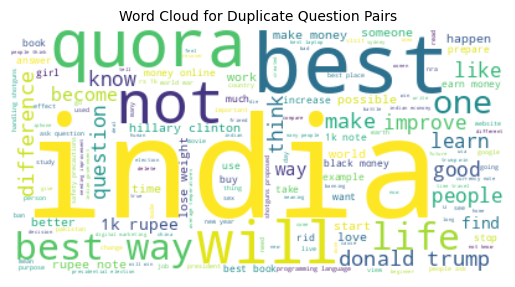

In [13]:
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
#print("Word Cloud for Duplicate Question Pairs")
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Duplicate Question Pairs", fontsize=10)
plt.axis('off')
plt.show()

###### Generating Word Cloud for Non-Duplicate Question Pairs

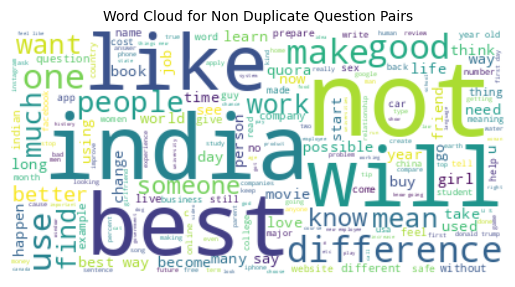

In [14]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
#print("Word Cloud for Duplicate Question Pairs")
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Non Duplicate Question Pairs", fontsize=10)
plt.axis('off')
plt.show()

In [15]:
def feature_plot_analyse(data,feature_name): 
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.violinplot(x='is_duplicate', y = feature_name, data=data)
   
    plt.subplot(1,2,2)
    sns.distplot(data[data['is_duplicate']==1][feature_name], label='1', color='red')
    sns.distplot(data[data['is_duplicate']==0][feature_name], label='0', color='blue')

    plt.suptitle(feature_name)
    plt.show()

##### Distribution of fuzzy features : fuzz_ratio, token_sort_ratio, token_set_ratio, fuzz_partial_ratio

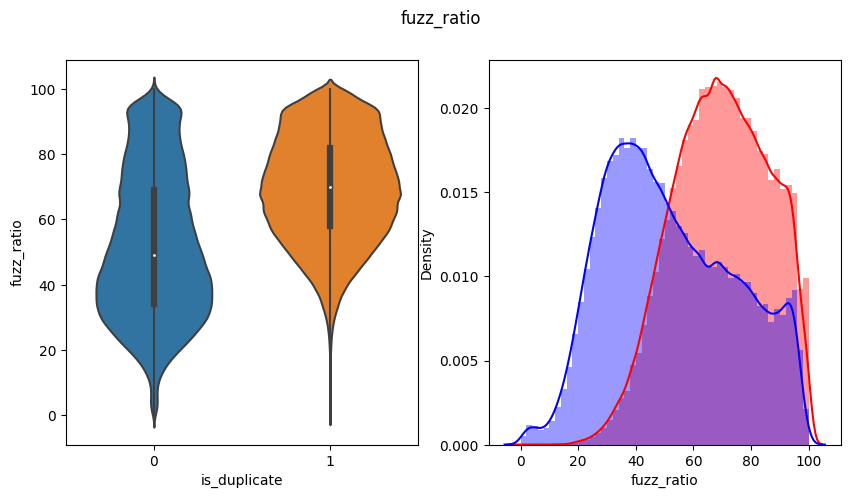

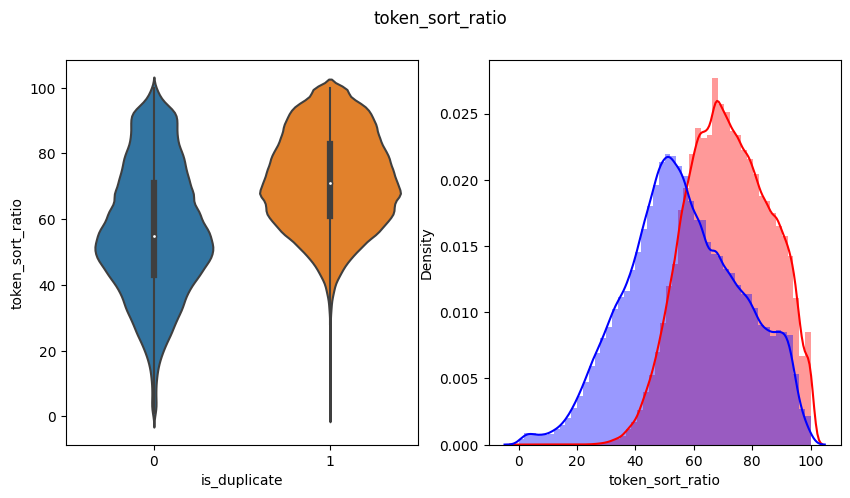

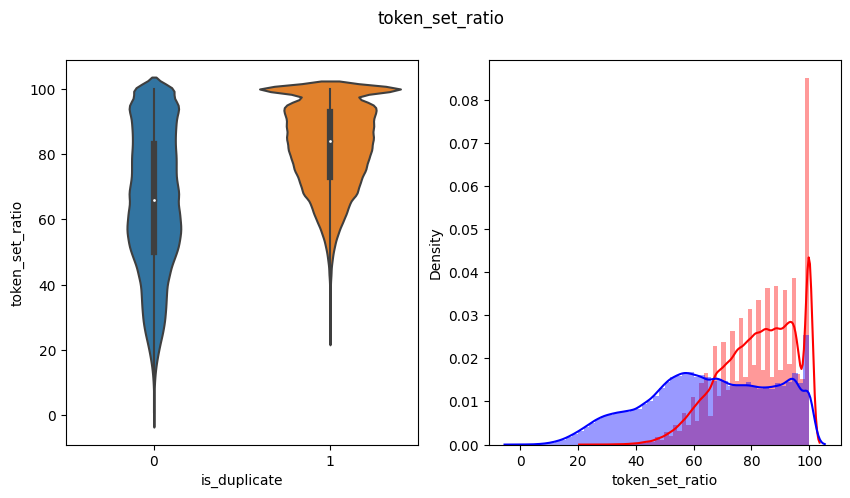

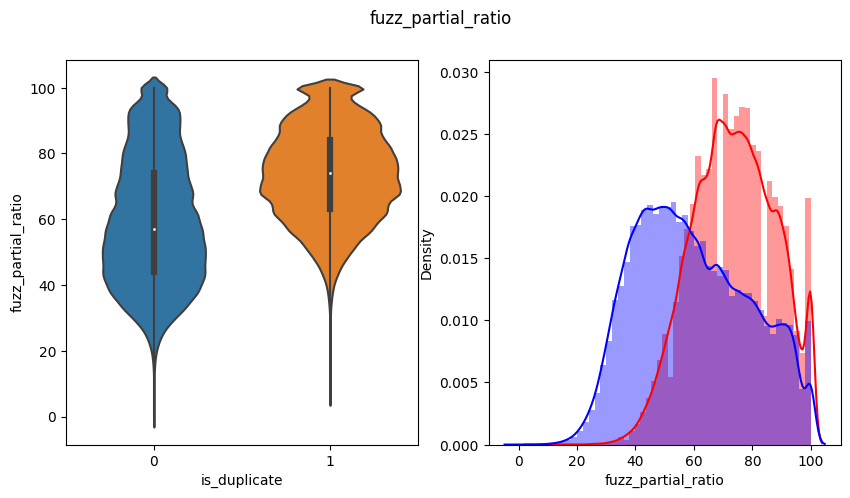

In [16]:
for feature in ['fuzz_ratio', 'token_sort_ratio', 'token_set_ratio', 'fuzz_partial_ratio']:
    feature_plot_analyse(df,feature)

##### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

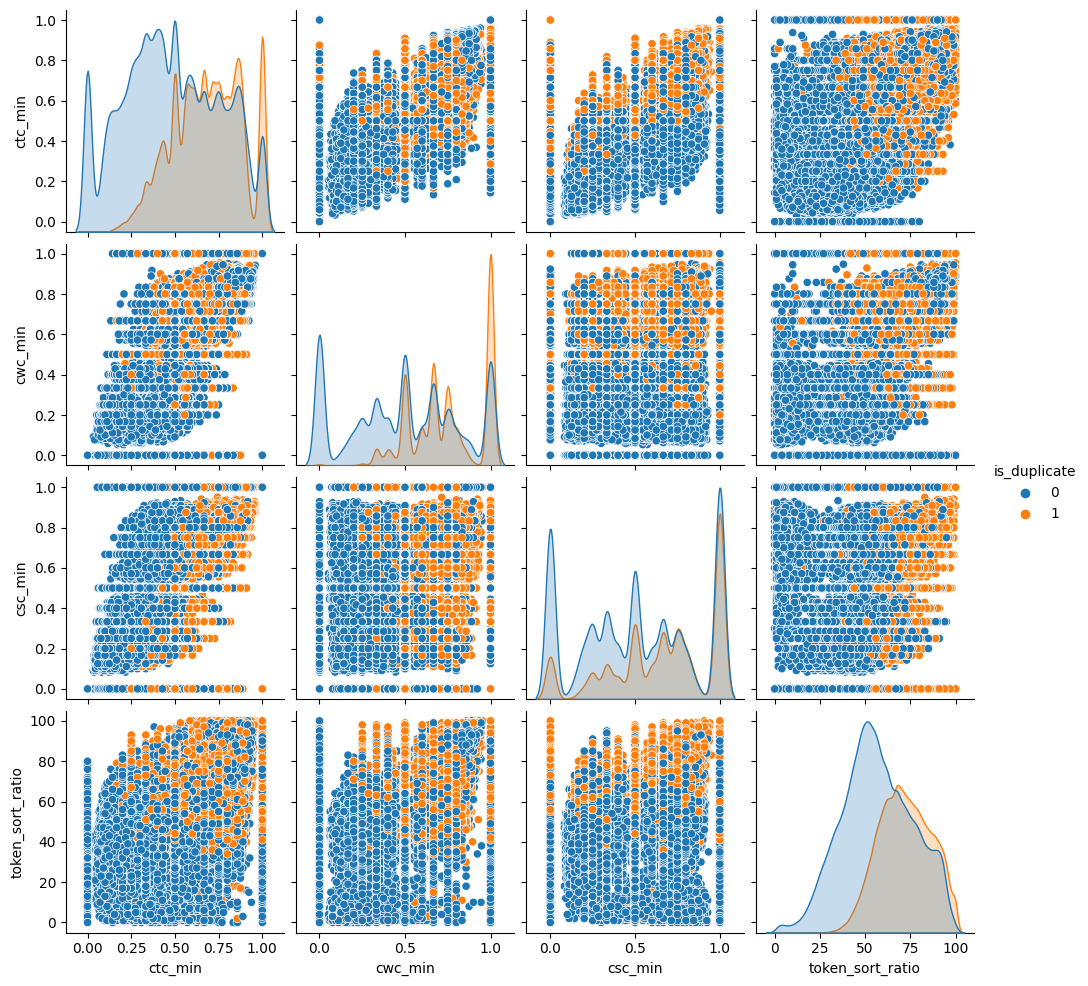

In [17]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [18]:
df.corr()

,id,qid1,qid2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
id,1.000000,0.629373,0.641993,-0.008784,-0.003187,-0.003440,-0.001441,-0.000735,-0.003210,-0.001930,-0.002341,0.000118,-0.000685,0.002502,-0.003813,-0.002903,-0.002253,-0.002495,-0.002405
qid1,0.629373,1.000000,0.700140,-0.247072,-0.113019,-0.104651,-0.059540,-0.064107,-0.100991,-0.097214,-0.071641,-0.063868,0.064584,0.040175,-0.113751,-0.098210,-0.102540,-0.095413,-0.065737
qid2,0.641993,0.700140,1.000000,-0.260101,-0.115708,-0.108001,-0.057301,-0.066875,-0.101610,-0.102173,-0.079462,-0.072920,0.076784,0.063618,-0.112930,-0.101523,-0.115066,-0.108644,-0.081683
is_duplicate,-0.008784,-0.247072,-0.260101,1.000000,0.402393,0.408924,0.216465,0.215323,0.366380,0.355543,0.307180,0.204780,-0.203541,-0.189038,0.397731,0.382402,0.384479,0.360354,0.264620
cwc_min,-0.003187,-0.113019,-0.115708,0.402393,1.000000,0.878414,0.428239,0.444053,0.811944,0.731269,0.390995,0.323253,-0.284764,-0.287567,0.855041,0.718836,0.689297,0.742515,0.704112
cwc_max,-0.003440,-0.104651,-0.108001,0.408924,0.878414,1.000000,0.470926,0.537494,0.789350,0.842201,0.436809,0.370048,-0.444926,-0.292303,0.827990,0.830002,0.795386,0.760919,0.699197
csc_min,-0.001441,-0.059540,-0.057301,0.216465,0.428239,0.470926,1.000000,0.876807,0.827232,0.761873,0.222056,0.617945,-0.159107,-0.040959,0.716338,0.637320,0.614219,0.605478,0.544836
csc_max,-0.000735,-0.064107,-0.066875,0.215323,0.444053,0.537494,0.876807,1.000000,0.782825,0.871913,0.287010,0.635225,-0.356890,-0.071762,0.713156,0.739846,0.725857,0.647127,0.580710
ctc_min,-0.003210,-0.100991,-0.101610,0.366380,0.811944,0.789350,0.827232,0.782825,1.000000,0.891696,0.357644,0.560931,-0.247663,-0.232822,0.938860,0.805501,0.779665,0.815039,0.760869
ctc_max,-0.001930,-0.097214,-0.102173,0.355543,0.731269,0.842201,0.761873,0.871913,0.891696,1.000000,0.413875,0.578579,-0.503647,-0.262808,0.868694,0.903310,0.881875,0.800609,0.725732
